### D. Pre-trained model: Visual Geometry Group-16 (VGG-16)

Initially assessment of the well-known pre-trained VGG16 model shows that it poorly predicts the three objects that are studied in this project (i.e., spoon, fork, and floss). The number 16 means that it consists of 16 weight layers [1]. This justifies the need to train this model. Due to its more complex architecture than the models that are dicussed in **Appendix B** and **C**, I believe that a trained VGG16 model will achieve a greater accuracy. 

**Table of Contents**

1. Initial Assessment  
2. Applying a custom training dataset   
3. References  
4. Summary  

***

#### 1. Initial Assessment

In [1]:
#dynamically set tensorflow backend
#https://stackoverflow.com/questions/49121112/how-do-i-set-the-keras-backend-in-python-dynamically-when-loaded-using-superviso
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import backend as K

from keras.utils import np_utils


C:\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#initial test
#https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

# load the model
model = VGG16()

In [3]:
# load an image from file
labels=["floss","fork","spoon"]

for i,image in enumerate(labels):
    image = load_img('Images/%s_test.jpg' %(image), target_size=(224, 224))

    # convert the image pixels to a numpy array
    image = img_to_array(image)

    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # prepare the image for the VGG model
    image = preprocess_input(image)

    # predict the probability across all output classes
    yhat = model.predict(image)

    # convert the probabilities to class labels
    label = decode_predictions(yhat)

    # retrieve the most likely result, e.g. highest probability
    label = label[0][0]

    # print the classification
    print('Predicted label: %s (%.2f%%); actual label: %s' % (label[1], label[2]*100, labels[i]))

Predicted label: envelope (14.83%); actual label: floss
Predicted label: spatula (59.51%); actual label: fork
Predicted label: hook (23.42%); actual label: spoon


- The built-in VGG model is unable to predict correctly any of the three objects (i.e., spoon, fork, and floss)
- Therefore, there is a need to re-train this model 

#### 2. Applying a custom training dataset 
#### 2.1. Load, prepare, and inspect data

In [4]:
#Load and inspect training dataset
import pandas as pd

df=pd.read_csv("Data/combined_rgb.csv")
df.head() #check

,0,1,2,3,4,5,6,7,8,9,...,17915,17916,17917,17918,17919,17920,17921,w,h,label
0,-0.985585,-1.065055,-1.200833,-0.929019,-1.005393,-1.137218,-0.985585,-1.005393,-1.137218,-0.872453,...,0.103278,0.202302,0.217666,0.230508,0.258869,0.217666,0.230508,103,3,spoon
1,-0.985585,-1.065055,-1.200833,-0.929019,-1.005393,-1.137218,-0.985585,-1.005393,-1.137218,-0.872453,...,0.103278,0.202302,0.217666,0.230508,0.258869,0.217666,0.230508,103,3,spoon
2,-0.985585,-1.065055,-1.200833,-0.929019,-1.005393,-1.137218,-0.985585,-1.005393,-1.137218,-0.872453,...,0.103278,0.202302,0.217666,0.230508,0.258869,0.217666,0.230508,103,3,spoon
3,-0.985585,-1.065055,-1.200833,-0.929019,-1.005393,-1.137218,-0.985585,-1.005393,-1.137218,-0.872453,...,0.103278,0.202302,0.217666,0.230508,0.258869,0.217666,0.230508,103,3,spoon
4,-0.985585,-1.065055,-1.200833,-0.929019,-1.005393,-1.137218,-0.985585,-1.005393,-1.137218,-0.872453,...,0.103278,0.202302,0.217666,0.230508,0.258869,0.217666,0.230508,103,3,spoon


In [5]:
X=df.iloc[:,:17922].as_matrix() #change to a matrix data type
X=X.reshape(X.shape[0],58, 103,3)#reshape data
#print(X.shape) #check

Y=df.iloc[:,17924]
#change Y to onehotencoder
#transform labels to labelBinarizer
#https://datascience.stackexchange.com/questions/17516/how-to-deal-with-string-labels-in-multi-class-classification-with-keras
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
transformed_label = encoder.fit_transform(["spoon", "fork", "floss"])

Y=encoder.transform(Y) #convert Y dataset to a LabelBinarizer
#Y #check

In [6]:
#split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [7]:
#check to make sure than you can retrieve the data and plot into an image
import matplotlib.pyplot as plt
import numpy as np


#reshape and view image
random_no=np.random.randint(len(X_train), size=1) #select a random number
#print(random_no) #check
#X_train.shape #check

check_random_image=X_train[random_no] #select an image at random
check_random_image.shape #check

(1, 58, 103, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


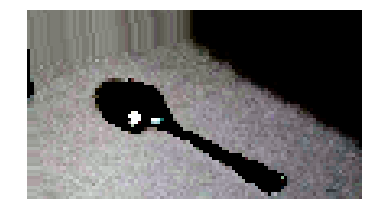

In [8]:
#plot the randomly selected image
plt.imshow(check_random_image.reshape(58,103,3))
plt.axis("off")
plt.show()

#### 2.2. Train model

*Define model architecture*

In [9]:
#code is taken from: https://github.com/lazyprogrammer/machine_learning_examples
#cnn_class2/use_pretrained_weights_vgg.py

from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

# re-size all the images to this
IMAGE_SIZE = [58, 103] # feel free to change depending on dataset, but the minimum dimension is 46x46.


# training config:
epochs = 10
batch_size = 32

*Build model*

In [10]:
# add preprocessing layer to the front of VGG
#note that the input data is defined as a 3-channel image
#           color_img = cv2.cvtColor(gray_img, cv.CV_GRAY2RGB)

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
#prediction = Dense(len(folders), activation='softmax')(x)
no_classes=3
prediction = Dense(no_classes, activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 58, 103, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 58, 103, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 58, 103, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 29, 51, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 29, 51, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 29, 51, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 25, 128)       0         
__________

*Fit data to model*

In [11]:
# Checkpoint the weights when validation accuracy improves
from keras.callbacks import ModelCheckpoint

# checkpoint
filepath="Models/vgg_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_vgg = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint_vgg]

#use this command for model fitting
history_vgg=model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=epochs,callbacks=callbacks_list)

Train on 252 samples, validate on 84 samples
Epoch 1/10
252/252 [==============================] - 32s 127ms/step - loss: 1.1305 - acc: 0.6786 - val_loss: 0.5179 - val_acc: 0.9643

Epoch 00001: val_acc improved from -inf to 0.96429, saving model to Models/vgg_weights-improvement-01-0.96.hdf5
Epoch 2/10
252/252 [==============================] - 32s 126ms/step - loss: 0.4927 - acc: 0.9444 - val_loss: 0.3513 - val_acc: 0.9643

Epoch 00002: val_acc did not improve
Epoch 3/10
252/252 [==============================] - 32s 127ms/step - loss: 0.3122 - acc: 0.9802 - val_loss: 0.2010 - val_acc: 0.9643

Epoch 00003: val_acc did not improve
Epoch 4/10
252/252 [==============================] - 32s 127ms/step - loss: 0.2428 - acc: 0.9762 - val_loss: 0.1514 - val_acc: 0.9762

Epoch 00004: val_acc improved from 0.96429 to 0.97619, saving model to Models/vgg_weights-improvement-04-0.98.hdf5
Epoch 5/10
252/252 [==============================] - 32s 126ms/step - loss: 0.2003 - acc: 0.9841 - val_loss: 

dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])


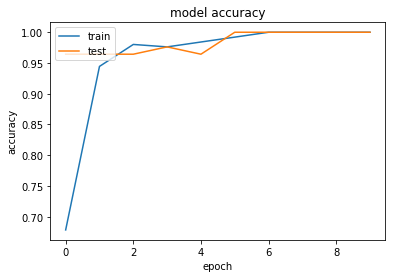

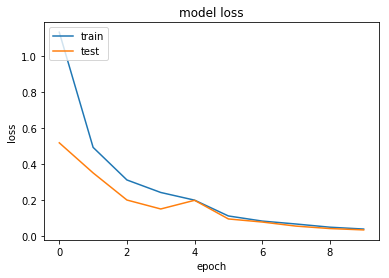

In [12]:
# list all data in history
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history_vgg.history.keys())


# summarize history for accuracy
plt.plot(history_vgg.history['acc'])
plt.plot(history_vgg.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 2.3. Make predictions

To validate model's accuracy, I feed it with images that are randomly taken from the internet.
    - spoon: http://www.peterhof.cc/classic-cutlery/733-dinner-spoon-6pcs-4895170314301.html
    - fork: https://www.amazon.com/Hiware-12-piece-Stainless-Dinner-Cutlery/dp/B01G8HUH8S
    - floss: https://greenspointdental.com/flossing-step-step-guide/

In [4]:
#https://datascience.stackexchange.com/questions/17516/how-to-deal-with-string-labels-in-multi-class-classification-with-keras
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

transformed_label = encoder.fit_transform(["floss", "fork", "spoon"])
#print(transformed_label) #check

In [5]:
#dynamically set tensorflow backend
#https://stackoverflow.com/questions/49121112/how-do-i-set-the-keras-backend-in-python-dynamically-when-loaded-using-superviso
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import backend as K

from keras.utils import np_utils

#code is adapted from: https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

#load model
from keras.models import load_model
load_model=load_model('Models/vgg_weights-improvement-06-1.00.hdf5')
load_model #check

The image is a: spoon (prob: [[0. 0. 1.]])


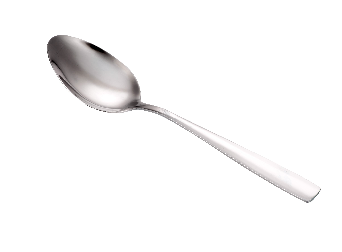

The image is a: fork (prob: [[0. 1. 0.]])


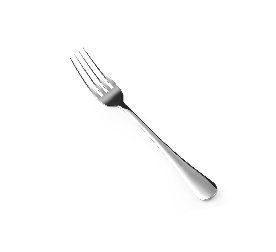

The image is a: floss (prob: [[0.86 0.14 0.  ]])


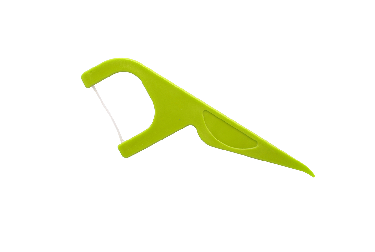

In [9]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

test_image_paths=['Images/spoon_test.jpg','Images/fork_test.jpg','Images/floss_test.jpg']

for test_image_path in test_image_paths:
    # load an image from file
    image = load_img(test_image_path, target_size=(58,103))


    from keras.preprocessing.image import img_to_array
    # convert the image pixels to a numpy array
    image = img_to_array(image)


    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) #convert a 3D to a 4D array

    from keras.applications.vgg16 import preprocess_input
    # prepare the image for the VGG model
    image = preprocess_input(image)

    # predict the probability across all output classes
    yhat = load_model.predict(image)

    import numpy as np
    predicted_label=np.around(yhat.astype(float),0)
    print('The image is a: %s (prob: %s)' %(encoder.inverse_transform(predicted_label)[0], np.around(yhat.astype('float'),2)))

    import cv2

    #plot the image
    plt.imshow(cv2.imread(test_image_path))
    plt.axis('off')
    plt.show()

#### 3. References 
    
1. http://www.robots.ox.ac.uk/~vgg/research/very_deep/
2. https://github.com/lazyprogrammer/machine_learning_examples
3. https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

#### 4. Summary

- Initial assessment shows that the built-in VGG model is unable to recognize any of the three objects (i.e., spoon, fork, and floss).
- This justifies the need to re-train the model using custom datasets.
- Using the pretrained model, an accuracy of 100% is achieved.
- Having trained the model with custom datasets, it is able to accurately predict the three objects from images randomly taken from the internet.
- The model is now ready to use.